In [1]:
import os
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa as tsa


''' Yahoo API does not work
Quandl needs Login Key
symbol = 'WIKI/AAPL'  # or 'AAPL.US'
df = web.DataReader(symbol, 'quandl', '2015-01-01', '2015-01-05')
'''

# Multiple series from FRED:
start = datetime.datetime(2009, 4, 20)
end = datetime.datetime(2019, 4, 18)
FredData = web.DataReader(['DEXUSEU', 'DGS10', 'DGS3MO'], 'fred', start, end)

C:\Users\Akhil\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


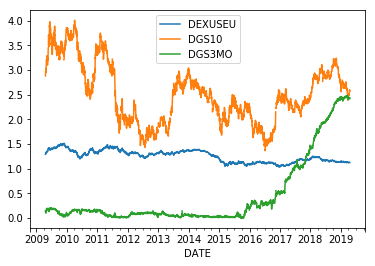

In [2]:
FredData.plot()

In [3]:
'''Add the Path to the directory all Data Files are stored'''
path="C:\\Users\Akhil\Documents\Econometrics"
os.chdir(path)
os.getcwd()

#### Load SPY index prices
SNPdata = pd.read_csv('GSPC.csv')  # 10 years data
SNPdata.set_index('Date', drop = True, inplace = True)
SNPdata = SNPdata['Adj Close']
SNPdata.rename(columns={'Adj Close':'SNP'}, inplace = True)
##Load GE
GEdata = pd.read_csv('GE.csv')  # 10 years data
GEdata.set_index('Date', drop = True, inplace = True)
GEdata = GEdata['Adj Close']
GEdata.rename(columns={'Adj Close':'GE'}, inplace = True)


#Change Index to DateTime
SNPdata.index = pd.to_datetime(SNPdata.index)
GEdata.index = pd.to_datetime(GEdata.index)

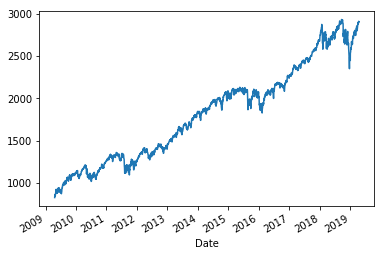

In [4]:
SNPdata.plot()

In [5]:
# Merge the two data sets
DataSet = pd.concat([SNPdata,GEdata, FredData], axis = 1).dropna()
DataSet.rename(columns = {0:'SNP', 1:'GE'}, inplace = True)
 
DataSet['SNPReturns'] = np.log(DataSet['SNP']).diff()
DataSet['GEReturns'] = np.log(DataSet['GE']).diff()
DataSet['deltaT'] = DataSet.index.to_series().diff().fillna(0).dt.days
DataSet['RF'] = np.log(1 + DataSet['DGS3MO']*0.01*DataSet['deltaT']/360)

DataSet.head()

,SNP,GE,DEXUSEU,DGS10,DGS3MO,SNPReturns,GEReturns,deltaT,RF
2009-04-20,832.390015,7.759925,1.2903,2.88,0.14,NaN,NaN,0,0.000000
2009-04-21,850.080017,7.999218,1.2978,2.94,0.15,0.021029,0.030371,1,0.000004
2009-04-22,843.549988,8.067589,1.3012,2.98,0.14,-0.007711,0.008511,1,0.000004
2009-04-23,851.919983,8.122285,1.3048,2.96,0.10,0.009873,0.006757,1,0.000003
2009-04-24,866.229980,8.279534,1.3277,3.03,0.10,0.016658,0.019175,1,0.000003


Text(0,0.5,'GE ExcessReturns')

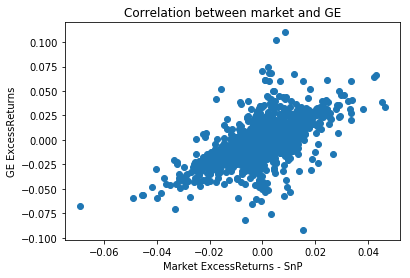

In [9]:
RPFminusRf = (DataSet['GEReturns'] - DataSet['RF']).dropna() 
RMktminusRf = (DataSet['SNPReturns'] - DataSet['RF']).dropna()

#Scatter Plot
plt.plot(RMktminusRf, RPFminusRf, 'o')
plt.title('Correlation between market and GE')
plt.xlabel('Market ExcessReturns - SnP')
plt.ylabel('GE ExcessReturns')


In [11]:
'''Finally run the regressions!!'''
RMktminusRf = sm.add_constant(RMktminusRf)
model = sm.OLS(RPFminusRf,RMktminusRf)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     1716.
Date:                Mon, 29 Apr 2019   Prob (F-statistic):          1.09e-285
Time:                        16:59:33   Log-Likelihood:                 7346.3
No. Observations:                2490   AIC:                        -1.469e+04
Df Residuals:                    2488   BIC:                        -1.468e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.895      0.0

R-Squared is basically the proportion of Variance of the $Y$ variables  that can be explained by the variance of the independent variables (i.e. $SSModel{/}SSTotal$.
F-Stat is related, in that it checks the $H_{0}$ that all Betas are 0. This is governed by: $F-{stat}$ =  $SSModel/SSquaredResiduals$. If it is high enough, then we reject the null hypothesis and can agree that atleast one of the betas is significance and the model makes sense!

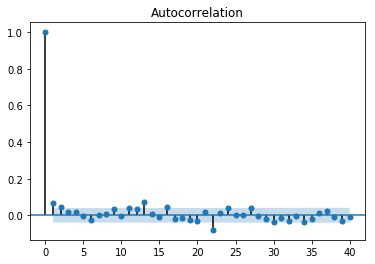

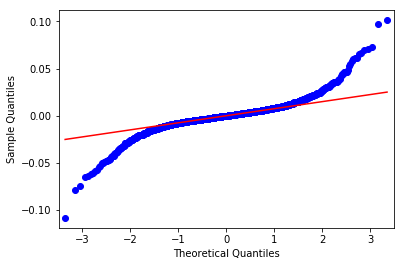

In [13]:
Residuals = res.resid
tsaplots.plot_acf(Residuals, lags=40)
from statsmodels.graphics.api import qqplot
qqplot(Residuals, line='q');

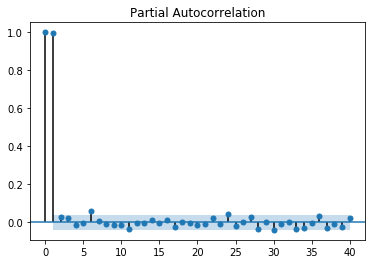

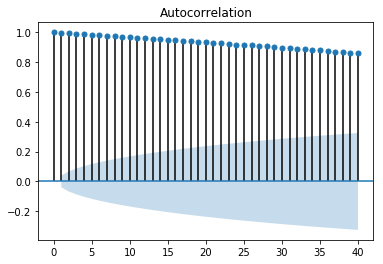

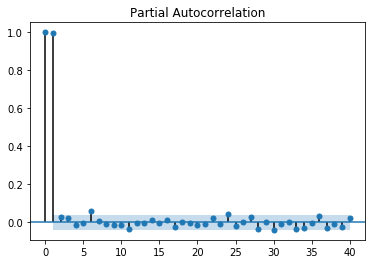

In [14]:
# Some Time Series Analysis

DGS10daily = FredData['DGS10'].dropna()

'''
DGS10daily['Year'] = DGS10daily.index.year
DGS10daily['Month'] = DGS10daily.index.month
DGS10daily['Weekday Name'] = DGS10daily.index.weekday_name
'''
tsaplots.plot_acf(DGS10daily, lags=40)   

tsaplots.plot_pacf(DGS10daily, lags=40)



The high first-order auto-correlation suggests that the > # time series has a unit root
The partial ACF removes the contribution of previous lag auto correlations  by regression them outand hence gives us the potential order of differencing needed
Another thing is that this shows how Levels are not stationary 


In [16]:
'''Conduct Augmented Dickey-Fuller Test for Unit Roots
First Conduct for the Un Differenced Series and then for the first differenced series
'''

ADF1 = tsa.stattools.adfuller(DGS10daily)
pValue1 = ADF1[1]  
print(pValue1)

0.28452846893993144


Hence the Null  hypothesis, which means Series has a Unit Root is not rejected (could have been rejected had p-value been less than 5%).. i.e. H0 is acccepted, series is not stationary
The Critical Values are based on Tables in Mackinnon


In [18]:
DGS10dailyDiff = DGS10daily.diff().dropna()
ADF2 = tsa.stattools.adfuller(DGS10dailyDiff)
pValue2 = ADF2[1]
print(pValue2)

0.0


ADF statistic  = -23.8584 and the P-value = 0!!! this series has No Unit roots
